# FlowAdapter M2

## Imports

In [1]:
import os
import random
import argparse
from pathlib import Path
import json
import itertools
import time
import ruamel.yaml as yaml
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from transformers import CLIPImageProcessor
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, DDIMScheduler
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy
from PIL import Image

from transformers import CLIPTextModel, CLIPTokenizer, CLIPVisionModelWithProjection

from ip_adapter.ip_adapter import ImageProjModel
from ip_adapter.utils import is_torch2_available
if is_torch2_available():
    from ip_adapter.attention_processor import IPAttnProcessor2_0 as IPAttnProcessor, AttnProcessor2_0 as AttnProcessor
else:
    from ip_adapter.attention_processor import IPAttnProcessor, AttnProcessor

from models_eyeformer.model_tracking import TrackingTransformer
from pytorchSoftdtwCuda.soft_dtw_cuda import SoftDTW
from tqdm.auto import tqdm

/home/researcher/anaconda3/envs/control/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/researcher/anaconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-08 19:10:03.922611: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 19:10:03.945768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions i

## Flow Encoders & Projectors

In [2]:
class FlowEncoder_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.add_module('encoder', nn.Sequential(
            nn.Linear(45, 128),
            nn.LeakyReLU(0.3),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.3),
            nn.Linear(512, 1024)))

        self.add_module('decoder', nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.3),
            nn.Linear(128, 45)))

    def forward(self, x):
      x = x.view(x.size(0), -1)
      x = self.encoder(x)
      x = self.decoder(x)
      return x

In [3]:
class FlowEncoder(nn.Module):
    def __init__(self, cross_attention_dim, clip_embeddings_dim, clip_extra_context_tokens, flow_latenizer):
        super().__init__()
        self.cross_attention_dim = cross_attention_dim
        self.clip_embeddings_dim = clip_embeddings_dim
        self.clip_extra_context_tokens = clip_extra_context_tokens
        self.flow_latenizer = flow_latenizer
    
    def forward(self, x):
        flow_embeds = x.view(x.size(0), -1)
        flow_embeds = self.flow_latenizer(flow_embeds)
        # print("Final flow_embeds Shape: ", flow_embeds.shape)
        return flow_embeds

In [4]:
class CorrectProjModel(nn.Module):
    """
    Correct the final flow embedding with a linear norm and final projection layer
    """

    def __init__(self, cross_attention_dim=1024, clip_embeddings_dim=1024, clip_extra_context_tokens=4):
        super().__init__()

        self.generator = None
        self.cross_attention_dim = cross_attention_dim
        self.clip_extra_context_tokens = clip_extra_context_tokens
        self.proj = torch.nn.Linear(clip_embeddings_dim, self.clip_extra_context_tokens * cross_attention_dim)
        self.norm = torch.nn.LayerNorm(cross_attention_dim)

    def forward(self, image_embeds):
        embeds = image_embeds
        clip_extra_context_tokens = self.proj(embeds).reshape(
            -1, self.clip_extra_context_tokens, self.cross_attention_dim
        )
        clip_extra_context_tokens = self.norm(clip_extra_context_tokens)
        return clip_extra_context_tokens

## Dataset 

In [5]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, json_file, tokenizer, size=256, 
                 t_drop_rate=0.05, i_drop_rate=0.05, 
                 ti_drop_rate=0.05, dataset_name="ueyes"):
        super().__init__()

        self.tokenizer = tokenizer
        self.size = size
        self.i_drop_rate = i_drop_rate
        self.t_drop_rate = t_drop_rate
        self.ti_drop_rate = ti_drop_rate
        self.dataset_name = dataset_name

        self.data = json.load(open(json_file)) # list of dict: [{"image_file": "1.png", "text": "A dog"}]

        self.transform = transforms.Compose([
            transforms.Resize(self.size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(self.size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
        # self.clip_image_processor = CLIPImageProcessor()
        

    def __getitem__(self, idx):
        item = self.data[idx] 
        text = item["prompt"]
        image_file = item["target"]
        
        # read image and flow vector
        raw_image = Image.open(image_file)
        image = self.transform(raw_image.convert("RGB"))

        # clip_image = self.clip_image_processor(images=raw_image, return_tensors="pt").pixel_values
        
        # drop
        drop_flow_embed = 0
        rand_num = random.random()
        if rand_num < self.i_drop_rate:
            drop_flow_embed = 1
        elif rand_num < (self.i_drop_rate + self.t_drop_rate):
            text = ""
        elif rand_num < (self.i_drop_rate + self.t_drop_rate + self.ti_drop_rate):
            text = ""
            drop_flow_embed = 1
        # get text and tokenize
        text_input_ids = self.tokenizer(
            text,
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).input_ids
        
        # Added for flow-Adapter:
        if self.dataset_name == "ueyes": # NOT Implemented yet
            flow_input = item["flow_input"]
        else:
            flow_input = None

        return {
            "image": image,
            "text_input_ids": text_input_ids,
            # "clip_image": clip_image,
            "drop_flow_embed": drop_flow_embed,
            "flow_input": flow_input
        }


    def __len__(self):
        return len(self.data)
    

def collate_fn(data):
    images = torch.stack([example["image"] for example in data])
    text_input_ids = torch.cat([example["text_input_ids"] for example in data], dim=0)
    # clip_images = torch.cat([example["clip_image"] for example in data], dim=0)
    drop_flow_embeds = [example["drop_flow_embed"] for example in data]

    return {
        "images": images,
        "text_input_ids": text_input_ids,
        # "clip_images": clip_images,
        "drop_flow_embeds": drop_flow_embeds
    }

## IPAdapter (Custom)

In [351]:
def get_generator(seed, device):

    if seed is not None:
        if isinstance(seed, list):
            generator = [torch.Generator(device).manual_seed(seed_item) for seed_item in seed]
        else:
            generator = torch.Generator(device).manual_seed(seed)
    else:
        generator = None

    return generator

from typing import List
from diffusers.pipelines.controlnet import MultiControlNetModel
from ip_adapter.attention_processor import AttnProcessor, CNAttnProcessor, IPAttnProcessor
class IPAdapter(torch.nn.Module):
    """Custom variation"""
    def __init__(self, pipe, correct_proj_model, ckpt_path=None, num_tokens=4):
        super().__init__()
        self.num_tokens = num_tokens
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.pipe = pipe.to(self.device)
        self.correct_proj_model = correct_proj_model.to(self.device)
        self.adapter_modules = self.set_ip_adapter()

        if ckpt_path is not None:
            self.load_ip_adapter(ckpt_path)

        
    def set_ip_adapter(self):
        unet = self.pipe.unet
        attn_procs = {}
        for name in unet.attn_processors.keys():
            cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
            if name.startswith("mid_block"):
                hidden_size = unet.config.block_out_channels[-1]
            elif name.startswith("up_blocks"):
                block_id = int(name[len("up_blocks.")])
                hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
            elif name.startswith("down_blocks"):
                block_id = int(name[len("down_blocks.")])
                hidden_size = unet.config.block_out_channels[block_id]
            if cross_attention_dim is None:
                attn_procs[name] = AttnProcessor()
            else:
                attn_procs[name] = IPAttnProcessor(
                    hidden_size=hidden_size,
                    cross_attention_dim=cross_attention_dim,
                    scale=1.0,
                    num_tokens=self.num_tokens,
                ).to(self.device, dtype=torch.float16)
        unet.set_attn_processor(attn_procs)
        if hasattr(self.pipe, "controlnet"):
            if isinstance(self.pipe.controlnet, MultiControlNetModel):
                for controlnet in self.pipe.controlnet.nets:
                    controlnet.set_attn_processor(CNAttnProcessor(num_tokens=self.num_tokens))
            else:
                self.pipe.controlnet.set_attn_processor(CNAttnProcessor(num_tokens=self.num_tokens))


    def forward(self, noisy_latents, timesteps, encoder_hidden_states, flow_embeds):
        # print("flow_embeds shape: ", flow_embeds.shape)
        # print("encoder_hidden_states shape: ", encoder_hidden_states.shape)
        ip_tokens = self.correct_proj_model(flow_embeds)
        # print("ip_tokens shape: ", ip_tokens.shape)
        
        encoder_hidden_states = torch.cat([encoder_hidden_states, ip_tokens], dim=1)
        # Predict the noise residual
        noise_pred = self.unet(noisy_latents, timesteps, encoder_hidden_states).sample
        return noise_pred


    def load_ip_adapter(self, ckpt_path):
        state_dict = torch.load(ckpt_path, map_location="cpu")
        self.correct_proj_model.load_state_dict(state_dict["flow_proj"])
        ip_layers = torch.nn.ModuleList(self.pipe.unet.attn_processors.values())
        ip_layers.load_state_dict(state_dict["ip_adapter"])
        print(f"Successfully loaded IP Adapter from checkpoint {ckpt_path}")
    

    def load_from_checkpoint(self, ckpt_path: str):
        # Calculate original checksums
        orig_ip_proj_sum = torch.sum(torch.stack([torch.sum(p) for p in self.correct_proj_model.parameters()]))
        orig_adapter_sum = torch.sum(torch.stack([torch.sum(p) for p in self.adapter_modules.parameters()]))

        state_dict = torch.load(ckpt_path, map_location="cpu")

        # Load state dict for correct_proj_model and adapter_modules
        self.correct_proj_model.load_state_dict(state_dict["flow_proj"], strict=True)
        self.adapter_modules.load_state_dict(state_dict["ip_adapter"], strict=True)

        # Calculate new checksums
        new_ip_proj_sum = torch.sum(torch.stack([torch.sum(p) for p in self.correct_proj_model.parameters()]))
        new_adapter_sum = torch.sum(torch.stack([torch.sum(p) for p in self.adapter_modules.parameters()]))

        # Verify if the weights have changed
        assert orig_ip_proj_sum != new_ip_proj_sum, "Weights of correct_proj_model did not change!"
        assert orig_adapter_sum != new_adapter_sum, "Weights of adapter_modules did not change!"

        print(f"Successfully loaded weights from checkpoint {ckpt_path}")


    @torch.inference_mode()
    def get_projected_flow_embeds(self, flow_embeds=None):
        flow_embeds = flow_embeds.to(self.device, dtype=torch.float32)
        correct_flow_embeds = self.correct_proj_model(flow_embeds)
        uncond_image_prompt_embeds = self.correct_proj_model(torch.zeros_like(flow_embeds))
        return correct_flow_embeds, uncond_image_prompt_embeds


    def set_scale(self, scale):
        for attn_processor in self.pipe.unet.attn_processors.values():
            if isinstance(attn_processor, IPAttnProcessor):
                attn_processor.scale = scale


    def generate(self,
        flow_embeds=None,
        prompt=None,
        negative_prompt=None,
        scale=1.0,
        num_samples=4,
        seed=None,
        guidance_scale=7.5,
        num_inference_steps=30,
        **kwargs):
        self.set_scale(scale)

        num_prompts = flow_embeds.size(0)

        if prompt is None:
            prompt = "best quality, high quality, no human, user interfaces"
        if negative_prompt is None:
            negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, human"

        if not isinstance(prompt, List):
            prompt = [prompt] * num_prompts
        if not isinstance(negative_prompt, List):
            negative_prompt = [negative_prompt] * num_prompts

        flow_prompt_embeds, uncond_flow_prompt_embeds = self.get_projected_flow_embeds(flow_embeds=flow_embeds)
        bs_embed, seq_len, _ = flow_prompt_embeds.shape
        flow_prompt_embeds = flow_prompt_embeds.repeat(1, num_samples, 1)
        flow_prompt_embeds = flow_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
        uncond_flow_prompt_embeds = uncond_flow_prompt_embeds.repeat(1, num_samples, 1)
        uncond_flow_prompt_embeds = uncond_flow_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)

        with torch.inference_mode():
            prompt_embeds_, negative_prompt_embeds_ = self.pipe.encode_prompt(
                prompt,
                device=self.device,
                num_images_per_prompt=num_samples,
                do_classifier_free_guidance=True,
                negative_prompt=negative_prompt)
            prompt_embeds = torch.cat([prompt_embeds_, flow_prompt_embeds], dim=1)
            negative_prompt_embeds = torch.cat([negative_prompt_embeds_, uncond_flow_prompt_embeds], dim=1)

        generator = get_generator(seed, self.device)

        images = self.pipe(
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
            **kwargs,
        ).images

        return images

## Args & Other Configs

In [352]:
class ARGS:
    pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
    pretrained_ip_adapter = "./sd-flow_adapter/custom_model_checkpoint-112000.pt"
    pretrained_flow_latenizer = "./sd-flow_adapter/checkpoint-112000/pytorch_model_1.bin"
    data_json_file = "/home/researcher/Documents/dataset/original_datasets/webui_prompts.json"
    resolution = 256
    dataloader_num_workers = 8
    dataset_name = "everything_else"
    output_dir = "./test_flowAdapter"
    designer_flow_choice = "ui" # "points" or "ui" 
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [353]:
args = ARGS()

## Load Models

In [354]:
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(args.pretrained_model_name_or_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(args.pretrained_model_name_or_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(args.pretrained_model_name_or_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(args.pretrained_model_name_or_path, subfolder="unet")

# attn_procs = {}
# unet_sd = unet.state_dict()
# for name in unet.attn_processors.keys():
#     cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
#     if name.startswith("mid_block"):
#         hidden_size = unet.config.block_out_channels[-1]
#     elif name.startswith("up_blocks"):
#         block_id = int(name[len("up_blocks.")])
#         hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
#     elif name.startswith("down_blocks"):
#         block_id = int(name[len("down_blocks.")])
#         hidden_size = unet.config.block_out_channels[block_id]
#     if cross_attention_dim is None:
#         attn_procs[name] = AttnProcessor()
#     else:
#         layer_name = name.split(".processor")[0]
#         weights = {
#             "to_k_ip.weight": unet_sd[layer_name + ".to_k.weight"],
#             "to_v_ip.weight": unet_sd[layer_name + ".to_v.weight"],
#         }
#         attn_procs[name] = IPAttnProcessor(hidden_size=hidden_size, 
#                                            cross_attention_dim=cross_attention_dim)
#         attn_procs[name].load_state_dict(weights)
# unet.set_attn_processor(attn_procs)
# adapter_modules = torch.nn.ModuleList(unet.attn_processors.values())

flowAE = FlowEncoder_MLP()
flow_latenizer = flowAE.encoder

if args.dataset_name == "ueyes":
    flowAE.load_state_dict(torch.load("/home/researcher/flowAE.pth")) # TODO: Put the right path here
    eyeFormer = None
else: 
    config = yaml.load(open("./configs/Tracking.yaml", 'r'), Loader=yaml.Loader)
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    yaml.dump(config, open(os.path.join(args.output_dir, 'config.yaml'), 'w'))
    eyeFormer = TrackingTransformer(config = config, init_deit=False)
    checkpointEF = torch.load("/home/researcher/Documents/aryan/asciProject/flowEncoder/weights/checkpoint_19.pth",
                            map_location='cpu')
    state_dict = checkpointEF['model']
    eyeFormer.load_state_dict(state_dict)
    
    eyeFormer.requires_grad_(False)
    eyeFormer.eval()

    eyeFormer.to(args.device)
    
flow_latenizer.requires_grad_(False)
        

Model will generate 16 points


Sequential(
  (0): Linear(in_features=45, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.3)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.3)
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): LeakyReLU(negative_slope=0.3)
  (6): Linear(in_features=512, out_features=1024, bias=True)
)

## Literally load state dicts and init flow encs

In [355]:
f =  torch.load(args.pretrained_flow_latenizer)
print(f.keys()) 
fix_flow_latenizer = {}
for key in f.keys():
    fix_flow_latenizer[key.replace("flow_latenizer.", "")] = f[key]
flow_latenizer.load_state_dict(fix_flow_latenizer)

flow_encoder = FlowEncoder(
        cross_attention_dim=unet.config.cross_attention_dim,
        clip_embeddings_dim=1024,
        clip_extra_context_tokens=4,
        flow_latenizer=flow_latenizer)
flow_encoder.to(args.device)
flow_projection_model = CorrectProjModel(
            cross_attention_dim=unet.config.cross_attention_dim,
            clip_embeddings_dim=1024,
            clip_extra_context_tokens=4)
# model_ckpt = torch.load("./sd-flow_adapter/custom_model_checkpoint-112000.pt")


odict_keys(['flow_latenizer.0.weight', 'flow_latenizer.0.bias', 'flow_latenizer.2.weight', 'flow_latenizer.2.bias', 'flow_latenizer.4.weight', 'flow_latenizer.4.bias', 'flow_latenizer.6.weight', 'flow_latenizer.6.bias'])


## Noise Scheduler

In [356]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(dtype=torch.float16)

In [357]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    args.pretrained_model_name_or_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [358]:
ip_adapter = IPAdapter(pipe, 
                       flow_projection_model,  
                       args.pretrained_ip_adapter)

Successfully loaded IP Adapter from checkpoint ./sd-flow_adapter/custom_model_checkpoint-112000.pt


In [359]:
softLoss = SoftDTW(use_cuda=True, gamma=0.1).to(args.device)
def get_soft_dtw_Loss(pred, target):
    loss = softLoss(pred, target)
    return loss

In [360]:
import matplotlib.pyplot as plt
def visualize_all(images, results, flow_input):
    for image, result in enumerate(zip(images, results)):
        image = image.transpose(1, 2, 0)
        result = result.view(15,3).numpy()

        # Draw 15 points on 2 plt images side by side
        fig = plt.figure(figsize=(10, 5))
        plt.title(f'Preds(R), Orig(G)')
        
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.scatter(result[:, 0], result[:, 1], cmap='red', s=[20*(i+5) for i in range(len(result))])
        plt.plot(result[:, 0], result[:, 1], c='red')
        
        plt.subplot(1, 2, 2)
        plt.imshow(image)
        plt.scatter(flow_input[:, 0], 
                    flow_input[:, 1], 
                    cmap='green', 
                    s=[20*(i+5) for i in range(len(result))])
        plt.plot(flow_input[:, 0], flow_input[:, 1], c='green')
        plt.colorbar()
        plt.show()
        break
        

In [361]:
def eval_with_eyeFormer(images, eyeFormer, flow_input, visualize=False):
    
    results = []
    
    with torch.no_grad():
        for image in images:
            print("Image Shape: ", image.shape)
            # resize the image to 256x256
            image = Image.fromarray(image)
            image = image.resize((256, 256))
            image = transforms.ToTensor()(image).unsqueeze(0)
            image = image.float().to(args.device)
            flow_paths = eyeFormer(image)
            flow_paths = flow_paths.view(flow_paths.size(0), -1)
            results.append(flow_paths)
    return results

    # soft-dtw? OR visualize the flow paths
    soft_loss_total = 0.
    for image, results in enumerate(zip(images, results)):
        soft_loss_total += get_soft_dtw_Loss(results, flow_input)

    if visualize:
        visualize_all(images.cpu().numpy(), 
                      results.cpu(), 
                      flow_input.cpu().view(15,3).numpy())
  
    return soft_loss_total / len(images)

In [362]:
# TODO - A: Handcraft a flow vector
with torch.no_grad():
    if args.designer_flow_choice == "points":
        # TODO: Make an API to let the designer annotate on top of the segmentation mask 
        # (if they have it otherwise blank canvas) ---> Gradio

        ############################
        # NOTE: Why you assuming it is flattened already!! 
        # It's 15x3 from the designer!!!
        flow_vector = torch.randn(1, 45).to(torch.float16) # == flow_path
        ############################

        flow_embeds = flow_encoder(flow_vector)
        # images = ip_adapter.generate(flow_embeds=flow_embeds, num_samples=8, num_inference_steps=50, seed=42)
    elif args.designer_flow_choice == "ui": # Ready to go
       # image = Image.open("/home/researcher/Documents/dataset/original_datasets/WebUI/UI_images/440291.png").convert("RGB")
        input_image = Image.open("/home/researcher/Documents/dataset/original_datasets/WebUI/UI_images/1096.png").convert("RGB")
        input_image = input_image.resize((256, 256))
        input_image = transforms.ToTensor()(input_image).unsqueeze(0)
        input_image = input_image.float().to(args.device)
        
        flow_path = eyeFormer(input_image)
        # print(flow_path.shape, flow_path.dtype)
        flow_path = flow_path.view(1, -1)
        flow_embeds = flow_encoder(flow_path)
        # print(flow_embeds.shape, flow_embeds.dtype)
    else:
        raise ValueError("Invalid choice for designer_flow_choice")

In [365]:
images = ip_adapter.generate(flow_embeds=flow_embeds, 
                            num_samples=4, 
                            num_inference_steps=80, 
                            seed=np.random.randint(0, 1000000))

100%|██████████| 80/80 [00:14<00:00,  5.39it/s]


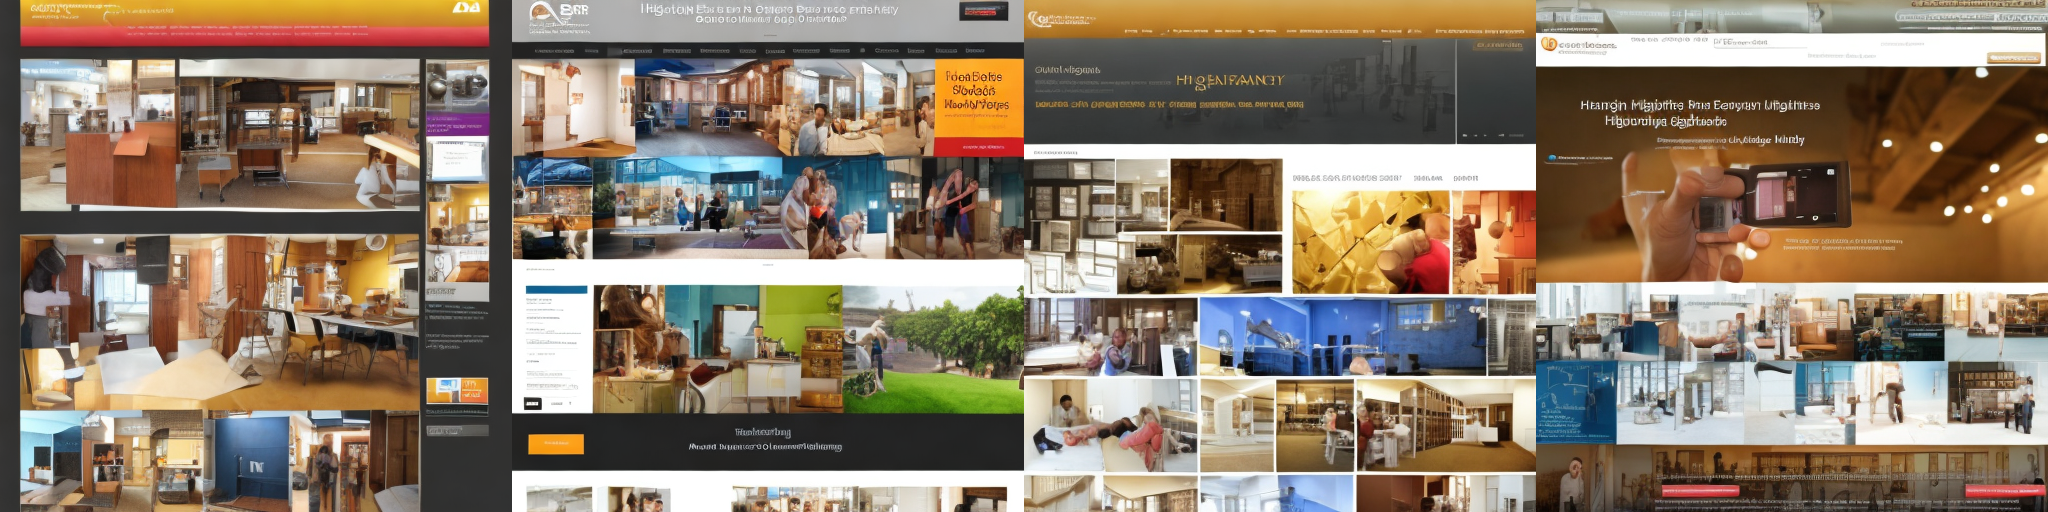

In [366]:
# generate image variations
grid = image_grid(images, 1, 4)
grid

## YJ TODO: Need to incorporate this in Inference code

In [367]:
import matplotlib.pyplot as plt

input_image = Image.open("/home/researcher/Documents/dataset/original_datasets/WebUI/UI_images/1096.png").convert("RGB")


def visualize_all_ui_input(images, results, flow_input):
    for image, result in zip(images, results):
        result = result.view(15,3).cpu().numpy()

        # input image width and height
        w, h = input_image.size[0], input_image.size[1]

        # resize the generated image to the input image size
        image = Image.fromarray(image)
        image = image.resize((w, h))

        # scale the flow_input to the image size
        flow_input[:, 0] = flow_input[:, 0] * w
        flow_input[:, 1] = flow_input[:, 1] * h

        # scale the result to the image size
        result[:, 0] = result[:, 0] * w
        result[:, 1] = result[:, 1] * h

        # Draw 15 points on 2 plt images side by side
        fig = plt.figure(figsize=(10, 5))
        plt.title(f'Orig(G), Preds(R)')
        
        # input image
        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(input_image)
        # NOTE: why image is not showing?
        plt.scatter(flow_input[:, 0], 
                    flow_input[:, 1], 
                    c='green', 
                    s=[10*(i+5) for i in range(len(result))])
        plt.plot(flow_input[:, 0], flow_input[:, 1], c='green')
      #  plt.colorbar()
        
        # generated image
        plt.subplot(1, 2, 2)
        plt.title("Generated Image")
        plt.imshow(image)
        plt.scatter(result[:, 0], result[:, 1], c='red', s=[10*(i+5) for i in range(len(result))])
        plt.plot(result[:, 0], result[:, 1], c='red')
        
        plt.show()
      #  break
        

In [368]:

def eval_with_eyeFormer(images, eyeFormer, flow_input, visualize=False):
    
    results = []
    
    with torch.no_grad():
        for image in images:

            # resize the image to 256x256
            image = Image.fromarray(image)
            image = image.resize((256, 256))
            image = transforms.ToTensor()(image).unsqueeze(0)
            image = image.float().to(args.device)
            flow_paths = eyeFormer(image)
            flow_paths = flow_paths.view(flow_paths.size(0), -1)
            results.append(flow_paths)
    
    # soft-dtw? OR visualize the flow paths
    soft_loss_total = 0.
   # for image, results in enumerate(zip(images, results)):
   #     soft_loss_total += get_soft_dtw_Loss(results, flow_input)

    if visualize:
        print("Visualizing")
        visualize_all_ui_input(images, 
                      results, 
                      flow_input.cpu().view(15,3).numpy())
  
    return soft_loss_total / len(images)

Visualizing


/tmp/ipykernel_677183/1597643167.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


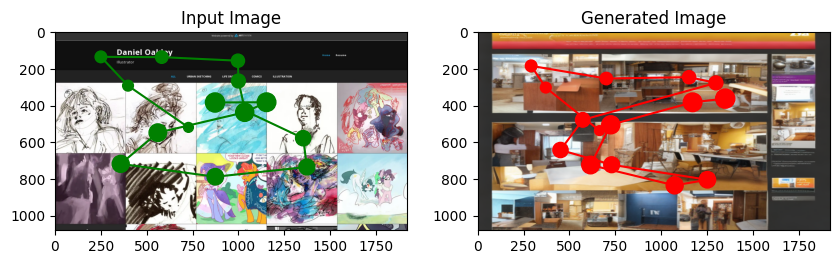

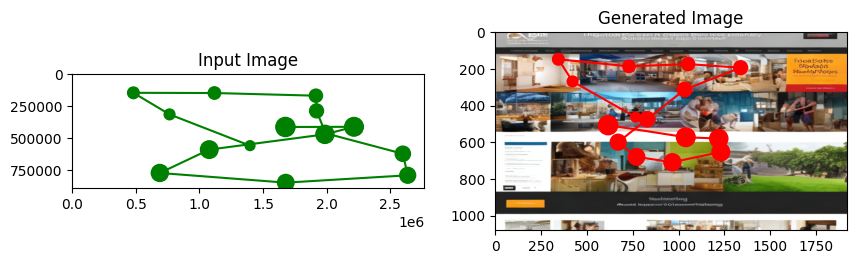

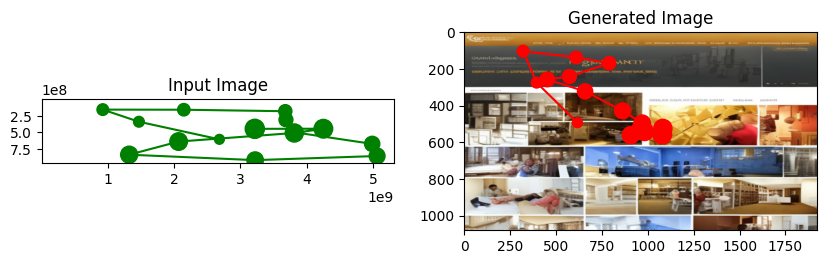

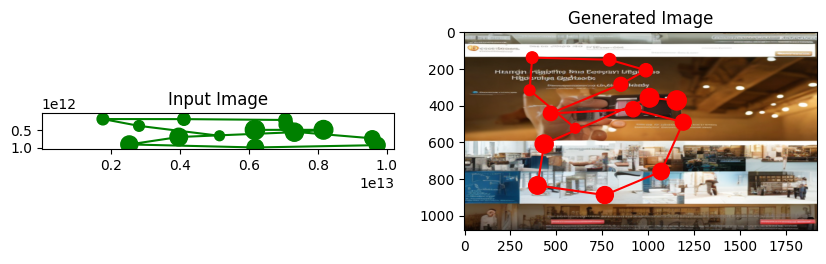

0.0

In [369]:
image_np = [np.array(img) for img in images]
eval_with_eyeFormer(image_np, eyeFormer, flow_path, visualize=True)